Вашей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.


данные:

Описания полей
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### Импорт библиотек

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings("ignore")

import datetime as DT

### Определение базовых функций

In [5]:
# Функция по сбору информации по каждому столбцу


def my_describe(df):
    """Отображение описательных статистик датафрейма в удобной форме"""
    temp = {}
    temp['Имя признака'] = list(df.columns)
    temp['Тип'] = df.dtypes
    temp['Всего значений'] = df.describe(include='all').loc['count']
    temp['Число пропусков'] = df.isnull().sum().values 
    temp['Кол-во уникальных'] = df.nunique().values
    temp['Минимум'] = df.describe(include='all').loc['min']
    temp['Максимум'] = df.describe(include='all').loc['max']
    temp['Среднее'] = df.describe(include='all').loc['mean']
    temp['Медиана'] = df.describe(include='all').loc['50%']
    temp = pd.DataFrame.from_dict(temp, orient='index')
    display(temp.T)
    return


def show_plot_boxplot(df, column, bins=80):
    """Построение гистограммы по столбцу и boxplot-а"""
    color_text = plt.get_cmap('PuBuGn')(0.9)
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = (10, 4)
    _, axes = plt.subplots(2, 1)
    axes[0].hist(df[column], bins=bins)
    axes[0].set_title("Гистограмма и boxplot для признака "+column)
    axes[1].boxplot(df[column], vert=False, showmeans = True)
    axes[1].set_title('')
    return


# Пропишем функцию расчета IQR и квартилей.

def IQR_perc(df,list_cols):
    temp = {}
    temp['Имя признака'] = list_cols
    temp['IQR'] = df[list_cols].quantile(0.75) - df[list_cols].quantile(0.25)
    temp['perc25'] = df[list_cols].quantile(0.25)
    temp['perc75'] = df[list_cols].quantile(0.75)
    temp['Л. граница выбросов'] = df[list_cols].quantile(0.25) - 1.5*(df[list_cols].quantile(0.75) - df[list_cols].quantile(0.25))
    temp['П. граница выбросов'] =df[list_cols].quantile(0.75) + 1.5*(df[list_cols].quantile(0.75) - df[list_cols].quantile(0.25))
    temp = pd.DataFrame.from_dict(temp, orient='index')
    display(temp.T)
    return



def show_confusion_matrix(y_true, y_pred):
    """Функция отображает confusion-матрицу"""
    color_text = plt.get_cmap('GnBu')(1.0)
    class_names = ['Дефолт', 'НЕ дефолт']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Матрица ошибок")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="GnBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Реальные значения', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()
    
    
def all_metrics(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['P'] = [P,'Дефолт']
    dict_metric['N'] = [N,'БЕЗ дефолта']
    dict_metric['TP'] = [TP,'Истинно дефолтные']
    dict_metric['TN'] = [TN,'Истинно НЕ дефолтные']
    dict_metric['FP'] = [FP,'Ложно дефолтные']
    dict_metric['FN'] = [FN,'Ложно НЕ дефолтные']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Точность = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Полнота = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC-AUC']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df) 

def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

### DATA

In [6]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [8]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


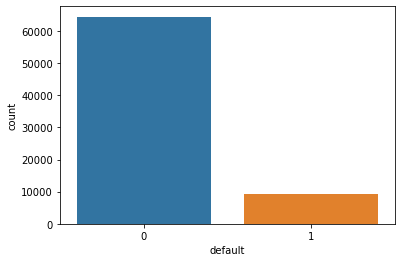

In [9]:
# Построит диаграмму для переменной  'default'  
ax = sns.countplot(x="default", data=df_train)

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [11]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [12]:
sample_submission.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [13]:
a = sample_submission.reset_index()
a

,index,client_id,default
0,0,66799,0.441004
1,1,25379,0.138092
2,2,28825,0.373370
3,3,37530,0.476501
4,4,4264,0.304640
...,...,...,...
24349,24349,96657,0.144776
24350,24350,65908,0.878936
24351,24351,74542,0.830871
24352,24352,82350,0.371539


In [14]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [15]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


# **Очистка и подготовка данных**

## Предобработка данных

In [16]:
# описываем функцию, заменяющую в строковых столбцах  пробел на None

def clear_column(column):
    return df[column].astype(str).apply(lambda x: None if x.strip() == '' else x)

for col in df.columns:
    clear_column(col)

## 1. Первичный отсмотр данных

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

### Работа с пропусками

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

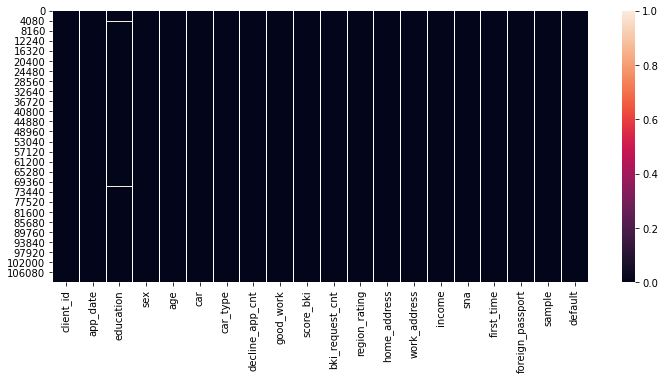

In [18]:
# построим карту пропусков данных
f, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(df.isnull(), cbar=True)
df.isnull().sum()

У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, даже отсутствие информации может быть важным признаком!
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак

In [19]:

# Подсчитаем общее число строк с пропусками
df.shape[0] - df.dropna().shape[0]

478

In [20]:
column = 'education'
print(f'Общая доля пропусков в столбце {column}:', round((df[column].isnull().value_counts(normalize=True) * 100),2)[1], '%')


Общая доля пропусков в столбце education: 0.43 %


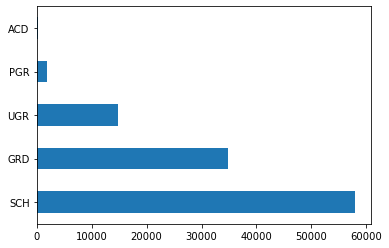

In [21]:
# посмотрим значения 'education'
df.education.value_counts().plot.barh()
plt.show()

In [22]:
#пропуски наблюдаем только в столбц "education". Создадим новый столбец с признаком пропуска данных в education
df['education_isNAN'] = pd.isna(df['education']).astype('uint8')

Заполним пропуски, исходя из того, что уровень образования должен коррелироваться с уровнем дохода:

In [23]:
# посмотрим каков для каждого типа образования средний доход
edu_income_mean = round(df.groupby(['education']).income.mean())
# отсортируем получившийся датафрейм
edu_income_mean.sort_values(inplace=True)

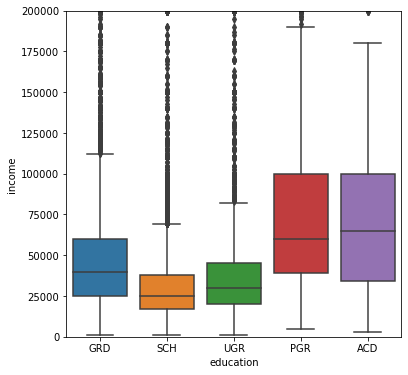

In [24]:
edu_income_mean
# SCH - school, ...., ACD - academic#
plt.figure(figsize=(6, 6))
plt.ylim(top=200_000)
ax = sns.boxplot(x="education", y="income", data=df)

In [25]:
# заполним пропуски в 'education' словом 'Unknown'
df['education'] = df['education'].fillna('Unknown')
# нулевым значениям в data['education'] присваиваем значение исходя из значения дохода в сравнении с вилкой среднего дохода
# для каждого типа образования c учетом датафрейма edu_income_mean


def insert_education(row):
    if row['education'] == 'Unknown':
        if row['income'] >= (edu_income_mean.iloc[4]+edu_income_mean.iloc[3])/2:
            return edu_income_mean.index[4]
        if (edu_income_mean.iloc[3]+edu_income_mean.iloc[2])/2 <= row['income'] < (edu_income_mean.iloc[4]+edu_income_mean.iloc[3])/2:
            return edu_income_mean.index[3]
        if (edu_income_mean.iloc[2]+edu_income_mean.iloc[1])/2 <= row['income'] < (edu_income_mean.iloc[3]+edu_income_mean.iloc[2])/2:
            return edu_income_mean.index[2]
        if (edu_income_mean.iloc[1]+edu_income_mean.iloc[0])/2 <= row['income'] < (edu_income_mean.iloc[2]+edu_income_mean.iloc[1])/2:
            return edu_income_mean.index[1]
        if row['income'] < (edu_income_mean.iloc[0]+edu_income_mean.iloc[1])/2:
            return edu_income_mean.index[0]
    return row['education']


df['education'] = df.apply(insert_education, axis=1)

In [26]:
df.education.value_counts()

SCH    58282
GRD    34829
UGR    14813
PGR     1888
ACD      336
Name: education, dtype: int64

# 2. Обработка признаков

Для начала посмотрим какие признаки у нас могут быть категориальныe, ,бинарные и числовые:

In [27]:
df.nunique(dropna=False)

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
education_isNAN          2
dtype: int64

In [28]:
pd.set_option('display.max_columns', None)
df.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,education_isNAN
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0,0


In [29]:
# сформируем списки столбцов по группам исходя из типов признаков
data_cols = ['app_date']
num_cols = ['age', 'bki_request_cnt', 'decline_app_cnt', 'income', 'score_bki']
bin_cols =['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'education_isNAN'] 
cat_cols =['education', 'region_rating', 'home_address','work_address', 'sna', 'first_time']

### 2.1. Временные ряды

In [30]:
column = 'app_date'
print(df[column].min())
print (df[column].max())

01APR2014
31MAR2014


In [31]:
# Преобразуем строковый признак 'app_date' в дату
df[column] = df[column].apply(lambda x: DT.datetime.strptime(x, '%d%b%Y').date())

In [32]:
# определим диапазон дат и вместо них, назначим признаком число дней от начальной (минимальной)даты.
print(df[column].min())
print(df[column].max())
start_date = df[column].min()
df[column] = df[column].apply(lambda x: (x - start_date).days)

2014-01-01
2014-04-30


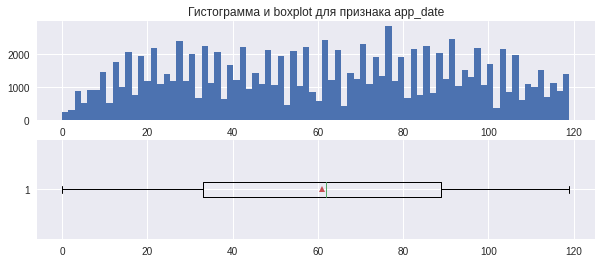

In [33]:
show_plot_boxplot(df,column)
num_cols.append(column)

In [34]:
# Для очистки тренировочного датасета от выбросов в числовых переменных, снова разделим общий датасет по признаку Sample
train_data = df.query('sample == 1')
test_data = df.query('sample == 0')

### 2.2. Числовые признаки

,Имя признака,IQR,perc25,perc75,Л. граница выбросов,П. граница выбросов
0,age,18,30,48,3,75
1,bki_request_cnt,3,0,3,-4.5,7.5
2,decline_app_cnt,0,0,0,0,0
3,income,28000,20000,48000,-22000,90000
4,score_bki,0.689703,-2.25953,-1.56983,-3.29409,-0.535277
5,app_date,56,33,89,-51,173


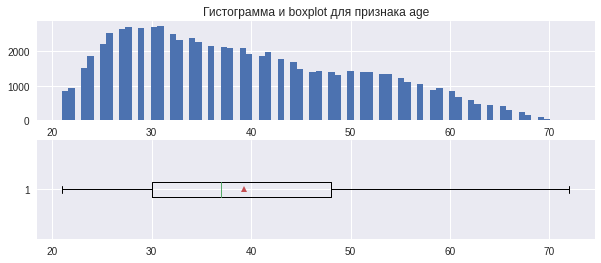

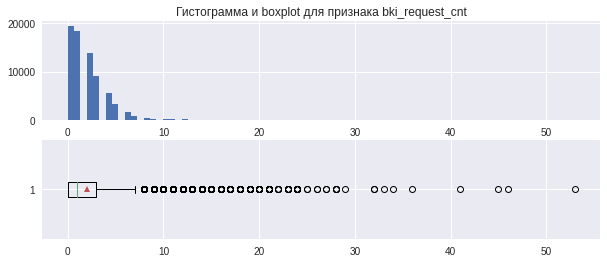

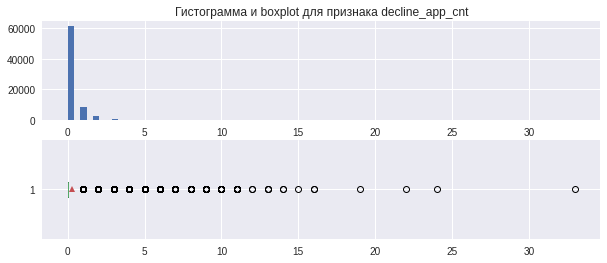

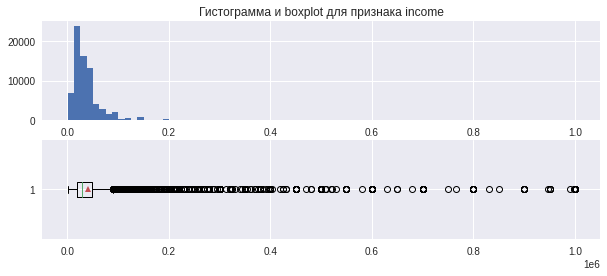

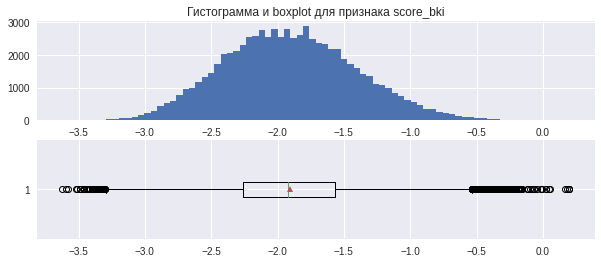

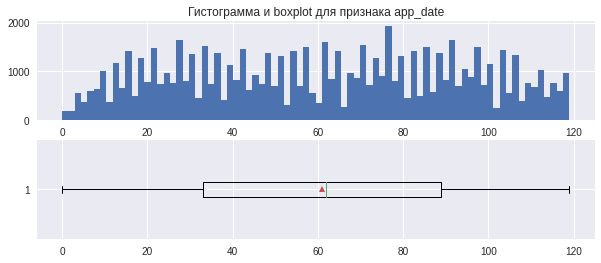

In [35]:
# посмотрим параметры IQR, гистограммы и боксплоты числовых признаков
IQR_perc(train_data, num_cols)
for column in num_cols:
    show_plot_boxplot(train_data,column)

После построения гистограмм стало очевидно, что распределения числовых переменных 'age', 'decline_app_cnt', 'bki_request_cnt', 'income' имеют тяжёлый правый хвост (у 'app_date' - левый), кроме того, почти все числовые признаки (кроме 'age' и 'app_date') содержат выбросы, к которым чувствительна LogisticRegression.

### 2.2.1 Удаление выбросов

In [36]:
# у столбцов 'age'и 'app_date'  на боксплотах нет выбросов, поэтому рассмотрим  другие 4 столбца  
# подсчитаем количество значений, лежащих за пределами границ выбросов в тренировочном датасете:

print('Количество значений за пределами границ выбросов в "bki_request_cnt":',\
        len(train_data.loc[train_data['bki_request_cnt'] > 7.5]))
print((len(train_data.loc[train_data['bki_request_cnt'] > 7.5]) /train_data.shape[0])*100, '% общего датасета')

print('Количество значений за пределами границ выбросов в "decline_app_cnt":',\
        len(train_data.loc[train_data['decline_app_cnt'] > 2]))
print((len(train_data.loc[train_data['decline_app_cnt'] > 2]) /train_data.shape[0])*100, '% общего датасета')
 
print('Количество значений за пределами границ выбросов в "income":',\
        len(train_data.loc[train_data['income'] > 90_000]))
print((len(train_data.loc[train_data['income'] > 90_000]) /train_data.shape[0])*100, '% общего датасета')

print('Количество значений за пределами границ выбросов в "score_bki":',\
        len((train_data.loc[train_data['score_bki'] > -0.52907]) + (train_data.loc[-3.29925 > train_data['score_bki']]))) 
print((len((train_data.loc[train_data['score_bki'] > -0.52907]) + \
                (train_data.loc[-3.29925 > train_data['score_bki']]))/train_data.shape[0])*100, '% общего датасета')


Количество значений за пределами границ выбросов в "bki_request_cnt": 1755
2.3780810038076394 % общего датасета
Количество значений за пределами границ выбросов в "decline_app_cnt": 1720
2.3306548869225874 % общего датасета
Количество значений за пределами границ выбросов в "income": 4695
6.361874822152061 % общего датасета
Количество значений за пределами границ выбросов в "score_bki": 340
0.4607108497405114 % общего датасета


In [37]:
# Удалим данные выбросы
train_data = train_data.drop(train_data[train_data['bki_request_cnt'] > 7.5].index)
train_data = train_data.drop(train_data[train_data['decline_app_cnt'] > 5].index)
train_data = train_data.drop(train_data[train_data['income'] > 90_000].index)
train_data = train_data.drop(train_data[train_data['score_bki'] > -0.52907].index)
train_data = train_data.drop(train_data[train_data['score_bki'] < -3.29925].index)     

,Имя признака,IQR,perc25,perc75,Л. граница выбросов,П. граница выбросов
0,age,18,30,48,3,75
1,bki_request_cnt,3,0,3,-4.5,7.5
2,decline_app_cnt,0,0,0,0,0
3,income,28000,20000,48000,-22000,90000
4,score_bki,0.692546,-2.26043,-1.56789,-3.29925,-0.52907
5,app_date,56,33,89,-51,173


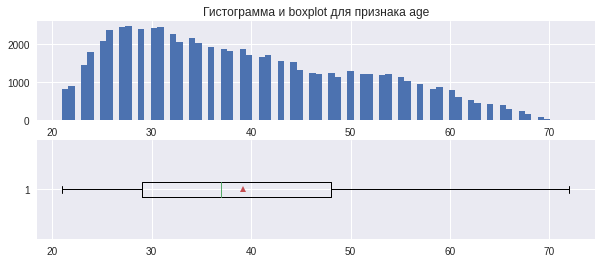

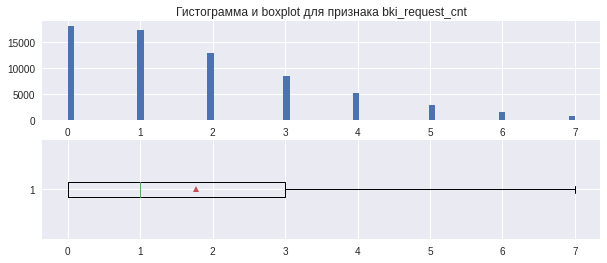

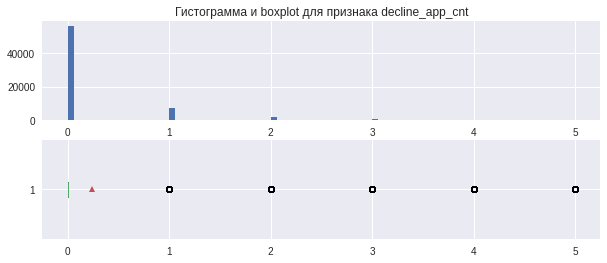

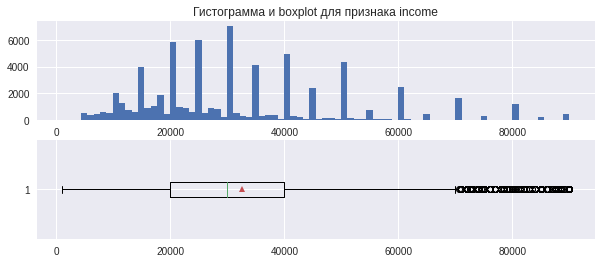

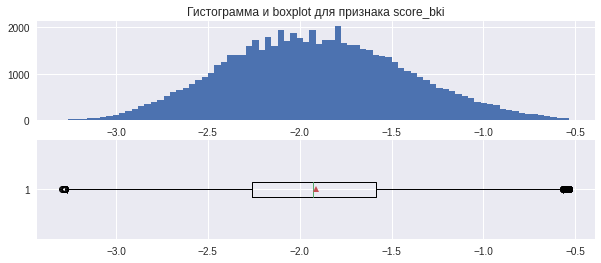

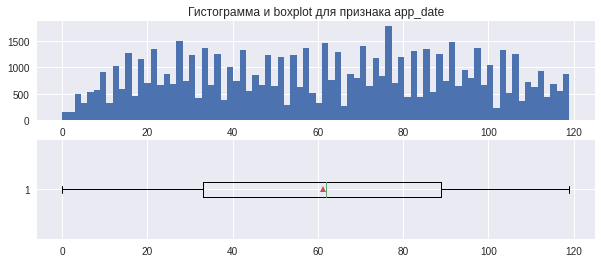

In [38]:
# посмотрим параметры IQR, гистограммы и боксплоты числовых признаков
IQR_perc(df, num_cols)
for column in num_cols:
    show_plot_boxplot(train_data,column)

In [39]:
# для дальнейшей обработки повторно объединим тренировочный и тесовый датасеты в один
df = test_data.append(train_data, sort=False).reset_index(drop=True)

Для того чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда можно избежать чувствительности к сильным отклонениям в суммах у линейных моделей.

Анализ распределений и boxplot-ов показывает, что признак 'score_bki' может быть как положительным, так и отрицательным, его логарифмировать напрямую нельзя, но его распределение и так похоже на нормальное. Возьмем логарифм от числовых признаков за исключением  'score_bki' и построим графики распределения логарифмированных переменных.

In [40]:
## только распределение 'score_bki' выглядит нормально
# прологарифмируем остальные столбцы, чтобы сделать распределение данных переменных более нормальным
num_cols.remove('score_bki')
df[num_cols] = df[num_cols].apply(lambda y: np.log(y+1))
num_cols.append('score_bki')

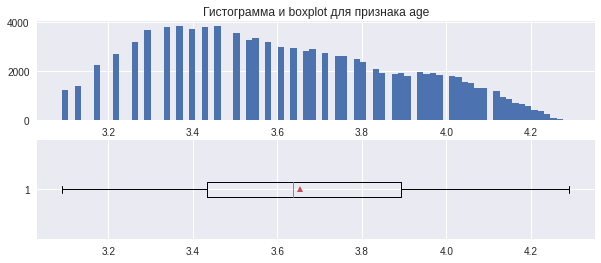

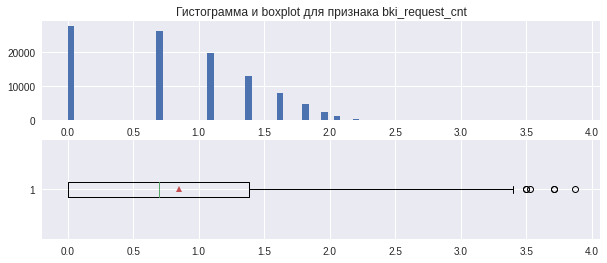

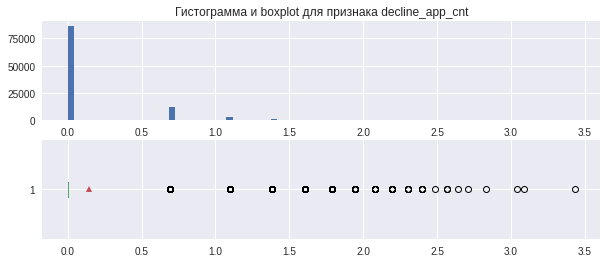

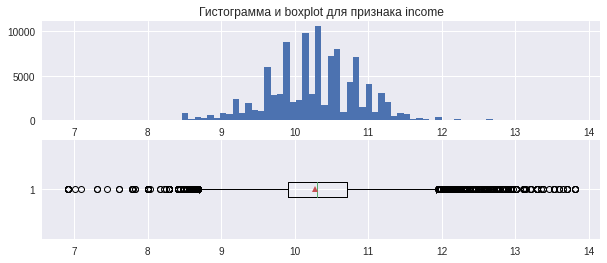

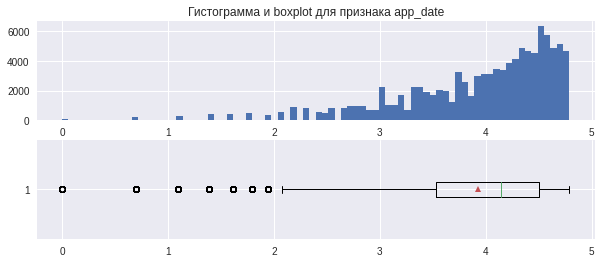

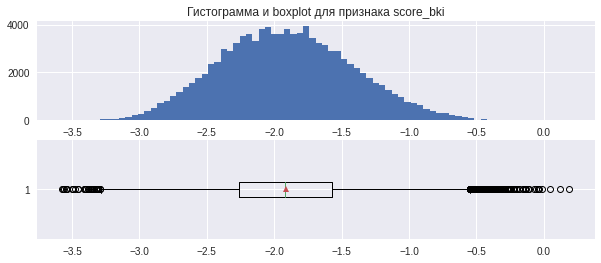

In [41]:
for column in num_cols:
    show_plot_boxplot(df,column)

После логарифмирования некоторые переменные стали менее смещёнными.

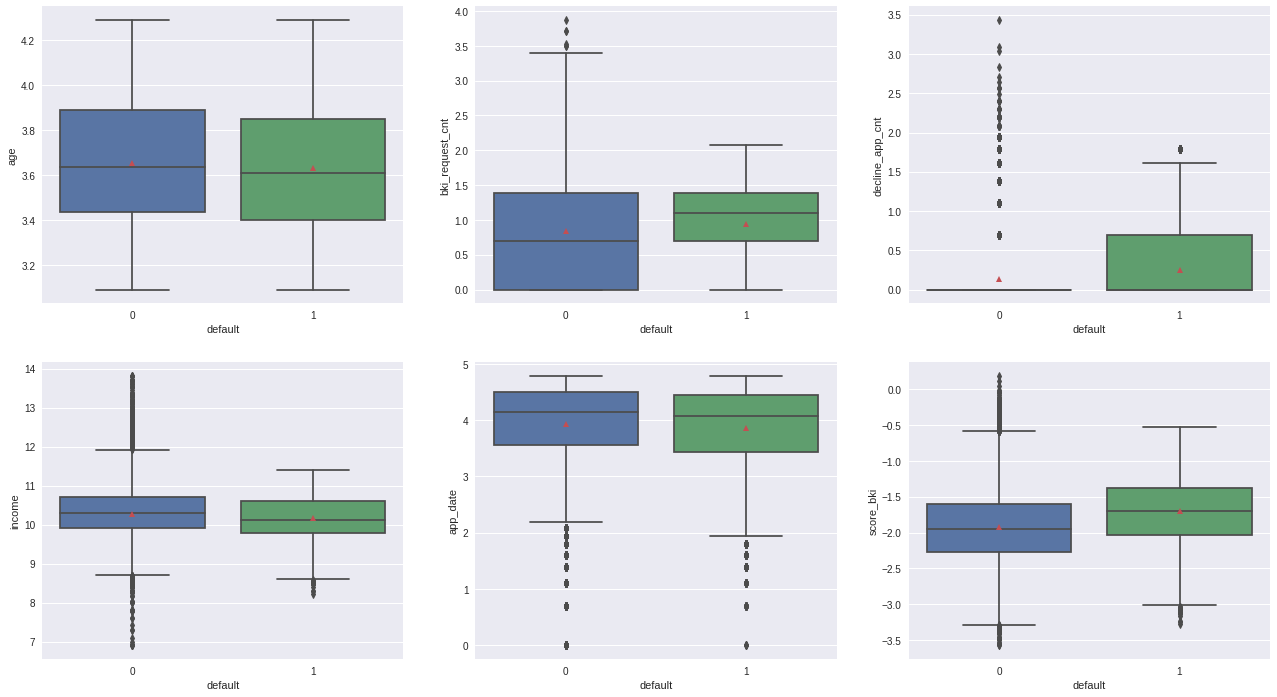

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
plt.subplots_adjust(wspace = 0.2)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=df, orient = 'v', ax=axes[i],  showmeans = True)

#### Выводы:
- age: Дефолтные клиенты в среднем: младше,
- 'bki_request_cnt': Дефолтные клиенты в среднем имеют больше запросов в БКИ
- 'decline_app_cnt' Дефолтные клиенты в среднем имеют большее количество отмененных заявок
- 'income': Дефолтные клиенты в среднем имеют более низкий доход-
- 'app_date': Дефолтные клиенты в среднем имеют более раннюю дату подачи заявки
- 'score_bki': Дефолтные клиенты в среднем имеют более высокий скорринговый балл. Возможно это связанно с тем, 
 что до этого более часто брали кредиты, и как следствие улучшали свою кредитную историю 

### 2.2.2 Корреляция

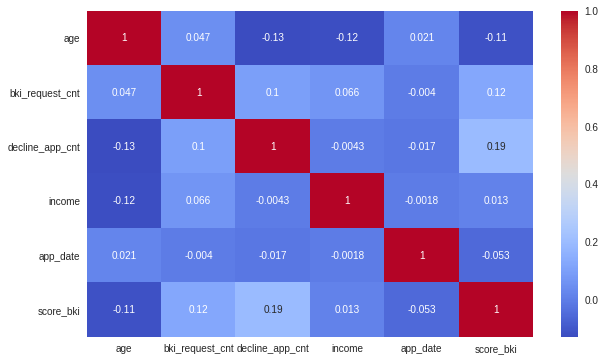

In [43]:
correlation = df[num_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Признаки между собой слабо скоррелированы, а значит мы оставляем их все. Никакой признак не удаляем

### 2.2.3 Значимость непрерывных переменных

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

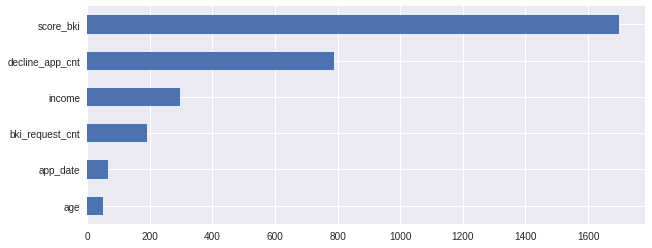

In [44]:
# Проанализируем наши числовые признаки
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Видим, что наиболее важным признаком явл. score_bki - скоринговый балл по данным из БКИ, а наименее важным - возраст (age)

## 2.3. Бинарные признаки

In [45]:
# Для перевода бинарных признаков в числа мы будем использовать LabelEncoder
# В алфавитном порядке: No=0, Yes=1

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,education_isNAN
0,74835,4.394449,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,0,0
1,17527,3.178054,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0,0
2,75683,4.406719,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,0,0
3,26883,3.526361,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,0,0
4,28862,3.555348,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,0,0,0


## 2.4. Категориальные признаки

In [46]:
# Переведем категориальные признаки в числа
# в алфавитном порядке => education{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}
label_encoder = LabelEncoder()

for column in cat_cols:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,education_isNAN
0,74835,4.394449,1,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,3,0,1,10.819798,0,3,0,0,0,0
1,17527,3.178054,3,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,3,0,1,8.517393,3,2,0,0,0,0
2,75683,4.406719,4,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,3,0,1,10.308986,0,2,1,0,0,0
3,26883,3.526361,3,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,2,0,1,9.741027,0,2,0,0,0,0
4,28862,3.555348,1,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,6,1,2,11.695255,0,2,0,0,0,0


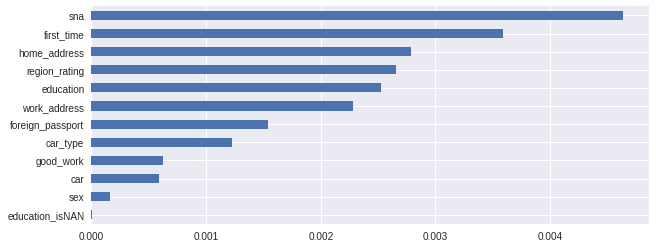

In [47]:
"""Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif 
из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии 
в группах категориальных переменных."""

imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Видим, что наиболее важным признаком явл. sna - связь заемщика с клиентами банка, а наименее важным -пол (sex), и вновь добавленый признак отсутствия (в датасете) образования - менее чем  у полупроцента людей из выборки

## 3. Подготовка данных к машинному обучению

Разбиваем датасет на тренировочный и тестовый, удалив лишние столбцы

In [48]:
train_data = df.query('sample == 1').drop(['sample', 'client_id'], axis=1)

test_data = df.query('sample == 0').drop(['sample','default'], axis=1)
# Сохраним ID клиентов из тестового набора для  формирования Submission
id_test = test_data.client_id
# Удалим ID клиентов из тестового набора для последующего формирования признакового проостранства
test_data = test_data.drop(['client_id'], axis=1)


# переведем категориальные данные в фиктивные переменные с удалением исходных столбцов из датафрейма
train = pd.get_dummies(train_data, columns=cat_cols, dummy_na=False, dtype='uint8')

In [49]:
train.head(2)

,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,education_isNAN,education_0,education_1,education_2,education_3,education_4,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,region_rating_5,region_rating_6,home_address_0,home_address_1,home_address_2,work_address_0,work_address_1,work_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3
36349,3.465736,1,4.143135,1,1,0.0,0,-2.008753,0.693147,9.798183,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
36350,4.262680,0,4.094345,0,0,0.0,0,-1.532276,1.386294,9.852247,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0


In [50]:
y = train.default.values            # наша целевая переменная
X = train.drop(['default'], axis=1)

In [51]:
# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53720, 38), (13430, 38), (53720,), (13430,))

## 4. Оценка качества модели

### 4.1 Модель без гиперпараметров

,Значение,Описание метрики
P,1718.000000,Дефолт
N,11712.000000,БЕЗ дефолта
TP,40.000000,Истинно дефолтные
TN,11669.000000,Истинно НЕ дефолтные
FP,43.000000,Ложно дефолтные
FN,1678.000000,Ложно НЕ дефолтные
Accuracy,0.871854,Accuracy=(TP+TN)/(P+N)
Precision,0.481928,Точность = TP/(TP+FP)
Recall,0.023283,Полнота = TP/P
F1-score,0.044420,Среднее гармоническое Precision и Recall


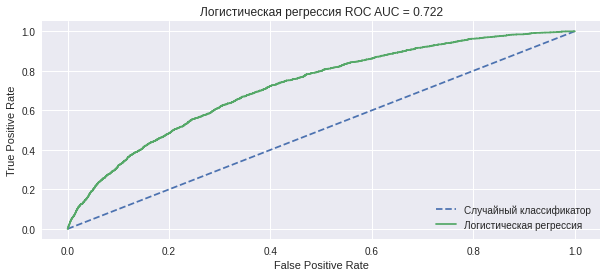

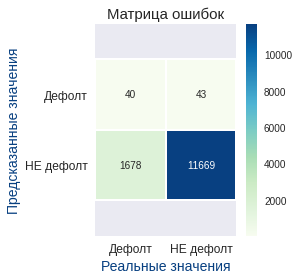

In [52]:
#model = LogisticRegression()
model_one = LogisticRegression(random_state=RANDOM_SEED)
model_one.fit(X_train, y_train)

# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_one.predict_proba(X_test)[:,1]
y_pred = model_one.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

##### ВЫВОДЫ: 
Не угаданы дефолтные клиенты. Несмотря на то, что ROC-AUC высокий (эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных). Значение точности, полноты и f1 сигнализирует о том что что-то не в порядке. Построенная модель очень плохая: из матрицы ошибок видно, что мы почти не угадываем дефолтных клиентов (40 из 1718). Это показывает и метрика recall = 0.023283. Таким образом, на основе выводов модели деньги будут выданы людям, которые их не смогут вернуть

### 4.2. Модель без гиперпараметров, но с нормализацией числовых признаков (RobastScaler)

Попробуем выполнить нормировку с помощью RobastScaler, которая при нормализации использует медианы и   квантили, поэтому не чувствительна к выбросам и может приводить к лучшим результатам.

,Значение,Описание метрики
P,1718.000000,Дефолт
N,11712.000000,БЕЗ дефолта
TP,40.000000,Истинно дефолтные
TN,11669.000000,Истинно НЕ дефолтные
FP,43.000000,Ложно дефолтные
FN,1678.000000,Ложно НЕ дефолтные
Accuracy,0.871854,Accuracy=(TP+TN)/(P+N)
Precision,0.481928,Точность = TP/(TP+FP)
Recall,0.023283,Полнота = TP/P
F1-score,0.044420,Среднее гармоническое Precision и Recall


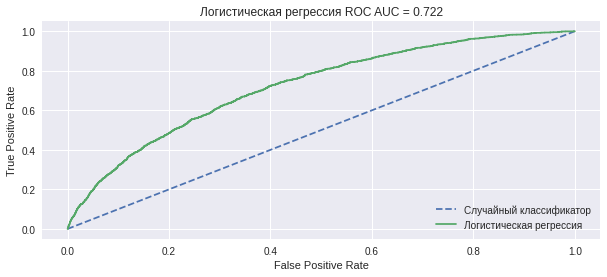

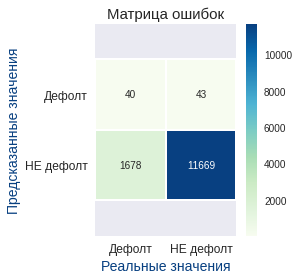

In [53]:
# При помощи RobastScaler нормируем числовые данные из тренировочного датасета сразу после разделения 
# и приводим к виду 2-мерного массива
X_num = RobustScaler().fit_transform(train_data[num_cols].values)
X_num_test = RobustScaler().fit_transform(test_data[num_cols].values)
# преобразуем категориальные данные в 2-х мерный массив, наподобие get_dummies
"""По умолчанию OneHotEncoder преобразует данные в разреженную матрицу(sparse = True), чтобы не расходовать память на хранение многочисленных 
нулей. При (sparse = False) вернет массив"""
X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)
# Объединяем (числовые, двоичные, и категориальные)
X = np.hstack([X_num, train_data[bin_cols].values, X_cat])
Test = np.hstack([X_num_test, test_data[bin_cols].values, X_cat_test])
y = train_data['default'].values

# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_two = LogisticRegression(random_state=RANDOM_SEED)

model_two.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_two.predict_proba(X_test)[:,1]
y_pred = model_two.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

ВЫВОД: RobustScaler не улучшил качество модели

### 4.3. Модель с гиперпараметрами

In [54]:
from sklearn.model_selection import GridSearchCV

C = np.logspace(0, 4, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,  
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C, 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C, 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Лучшее tol:', best_model.best_estimator_.get_params()['tol'])


Лучшее Penalty: l2
Лучшее C: 2.7825594022071245
Лучшее max_iter: 50
Лучшее tol: 0.001
35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


,Значение,Описание метрики
P,1718.000000,Дефолт
N,11712.000000,БЕЗ дефолта
TP,1117.000000,Истинно дефолтные
TN,7834.000000,Истинно НЕ дефолтные
FP,3878.000000,Ложно дефолтные
FN,601.000000,Ложно НЕ дефолтные
Accuracy,0.666493,Accuracy=(TP+TN)/(P+N)
Precision,0.223624,Точность = TP/(TP+FP)
Recall,0.650175,Полнота = TP/P
F1-score,0.332787,Среднее гармоническое Precision и Recall


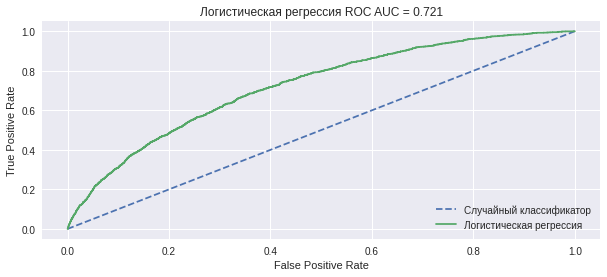

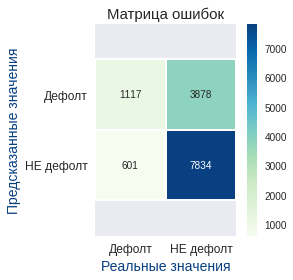

In [55]:
y = train.default.values            # наша целевая переменная
X = train.drop(['default'], axis=1)

# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# C=166.81
model_3 = LogisticRegression(penalty='l2', C=2.7825594022071245, max_iter=50, class_weight ='balanced', tol= 0.001)
model_3.fit(X_train, y_train)

# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_3.predict_proba(X_test)[:,1]
y_pred = model_3.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

ВЫВОДЫ: 
 - Построенная модель по сравнению с первой уже лучше определяет дефолтных клиентов, но в ней увеличилась ошибка распознавания не дефолтных клиентов. В такой ситуации банк рискует недополучить прибыль. Удалось увеличить показания Recall.
- Удаление малозначительных признаков 'education_isNAN', 'age' и 'sex' метрики модели не  улучшило, а ухудшило, в следствие чего признаки пришлось оставить

### Модель 4. Полиномиальные признаки, RobastScaler и гиперпараметры

In [56]:
# Преобразуем числовые признаки в полиномиальные
poly = PolynomialFeatures(3)
X_num = poly.fit_transform(train_data[num_cols].values)
X_num_test =poly.fit_transform(test_data[num_cols].values)
# При помощи RobastScaler нормируем числовые данные из тренировочного датасета сразу после разделения 
# и приводим к виду 2-мерного массива

X_num = RobustScaler().fit_transform(X_num)
X_num_test = RobustScaler().fit_transform(X_num_test)
# преобразуем категориальные данные в 2-х мерный массив, наподобие get_dummies
"""По умолчанию OneHotEncoder преобразует данные в разреженную матрицу(sparse = True), чтобы не расходовать память на хранение многочисленных 
нулей. При (sparse = False) вернет массив"""
X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)
# Объединяем (числовые, двоичные, и категориальные)
X = np.hstack([X_num, train_data[bin_cols].values, X_cat])
Test = np.hstack([X_num_test, test_data[bin_cols].values, X_cat_test])
y = train_data['default'].values

# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Находим лучшие гиперпараметры
from sklearn.model_selection import GridSearchCV

C = np.logspace(0, 4, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,  
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C, 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C, 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Лучшее tol:', best_model.best_estimator_.get_params()['tol'])

Лучшее Penalty: l2
Лучшее C: 464.15888336127773
Лучшее max_iter: 50
Лучшее tol: 0.001


,Значение,Описание метрики
P,1718.000000,Дефолт
N,11712.000000,БЕЗ дефолта
TP,1135.000000,Истинно дефолтные
TN,7664.000000,Истинно НЕ дефолтные
FP,4048.000000,Ложно дефолтные
FN,583.000000,Ложно НЕ дефолтные
Accuracy,0.655175,Accuracy=(TP+TN)/(P+N)
Precision,0.218985,Точность = TP/(TP+FP)
Recall,0.660652,Полнота = TP/P
F1-score,0.328938,Среднее гармоническое Precision и Recall


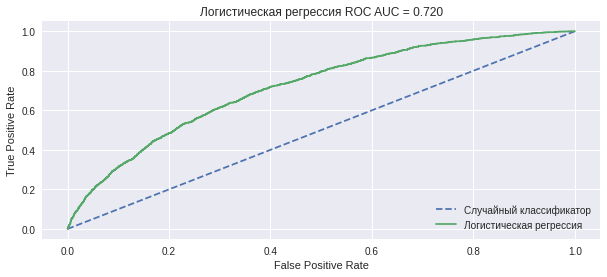

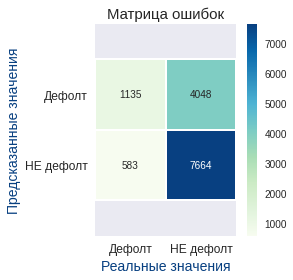

In [57]:
# Передача лучших гиперпараметров непосредственно в модель, что позволяет пропустить пункт обучения модели
#model_4 = best_model.best_estimator_


# Обучаем модель
model_4 = LogisticRegression(penalty='l2', C=464.15888336127773, max_iter=50, class_weight ='balanced', tol= 0.001, random_state=RANDOM_SEED)

model_4.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_4.predict_proba(X_test)[:,1]
y_pred = model_4.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)


ВЫВОДЫ: 
 - Построенная модель при добавлении полиномиальных признаков по сравнению с третьей  дала некоторое улучшение - recall немного улучшился

### 5. Submission

По ходу анализа набора данных  train соответствующие действия производились с набором test:

- заполнили пропуски в test.education исходя из значения дохода;
- преобразовали признак app_date (дата подачи заявки) в разницу между датой, указанной в столбце app_date и датой подачи первой заявки (01.01.2014) в днях;
- взяли логарифм от числовых признаков age, decline_app_cnt, bki_request_cnt, incom, app_date
- преобразовали бинарные переменные при помощи класса LabelEncoder;
- преобразовали признак education в численный формат;
- стандартизировали числовые признаки(RobustScaler), а также воспользоваться dummy-кодированием для категориальных переменных

Готовим Submission на кагл:

In [58]:
test_data.sample(3)


,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,education_isNAN
22269,4.477337,1,0,3.688879,0,0,0.000000,0,-1.109448,0.693147,3,0,1,10.463132,3,0,0,0
30218,4.343805,3,1,3.784190,1,1,0.000000,0,-2.005036,0.693147,6,1,2,11.407576,1,2,1,0
26146,4.653960,1,0,3.496508,0,0,0.693147,0,-0.665704,1.791759,5,1,2,10.714440,0,1,0,0


In [59]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [60]:
# Формируем свой submission
pred_prob_submission = model_4.predict_proba(Test)[:,1]

submission = pd.DataFrame({'client_id': id_test, 
                            'default': pred_prob_submission})
submission.to_csv('submission.csv', index=False)
submission

,client_id,default
0,74835,0.200364
1,17527,0.829622
2,75683,0.324190
3,26883,0.366516
4,28862,0.152302
...,...,...
36344,83775,0.803345
36345,106254,0.112833
36346,81852,0.755064
36347,1971,0.635116


#### В рамках имеющегося времени удалось:
- Построить 4 модели
- От дисбаланса классов  в выборке избавились посредство гиперпараметра class_weight ='balanced'
- Создать полиномиальные признаки
- Избавиться от выбросов в числовых признаках